In [29]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from collections import deque

# Import stable baselines
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env

# Import tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models

# Import custom classes
from Environment.env_v10 import *
from Functions.visualization_functions import *

# Import custom functions
from Functions.deep_q_learning import *

In [30]:
# Configuration of the network
with open('./Config/network_config_v2.json') as file:
    network_config = file.read()

EP_LENGTH = 100 # Length of the episode

In [31]:
def load_config(config_file):

    with open(config_file, "r") as f:
        config = json.load(f)
    return config

def make_env(config_file="config.json"):

    config = load_config(config_file)

    env = SS_Mngmt_Env(
        network_config=network_config,
        EP_LENGTH=EP_LENGTH,
        render_mode="human",
        model_type="heuristic",
        stockout_cost=config["stockout_cost"],
        order_cost=config["order_cost"],
        item_cost=config["item_cost"],
        stock_cost=config["stock_cost"],
        item_prize=config["item_prize"],
        progressive_stock_cost=config["progressive_stock_cost"],
        stock_out_max=config["stock_out_max"],
        order_quantities=config["order_quantities"],
        demand_mean=config["demand_mean"],
        demand_std=config["demand_std"],
        demand_noise=config["demand_noise"],
        demand_noise_std=config["demand_noise_std"],
        demand_prob=config["demand_prob"],
        extreme=True,
        seasonality=True,
        intermediate_reward=0,
    )

    return env

env = make_env("./Config/env_config_v0.json")

check_env(env, warn=True)

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:263: UserWarning: Your observation order_queues has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


Node Attributes:
Node A: {'type': 'manufacturer', 'I': 30}
Node B: {'type': 'manufacturer', 'I': 30}
Node C: {'type': 'manufacturer', 'I': 30}
Node E: {'type': 'manufacturer', 'I': 100}
Node F: {'type': 'manufacturer', 'I': 100}
Node G: {'type': 'manufacturer', 'I': 100}
Node D: {'type': 'distributor'}
Node S: {'type': 'source'}


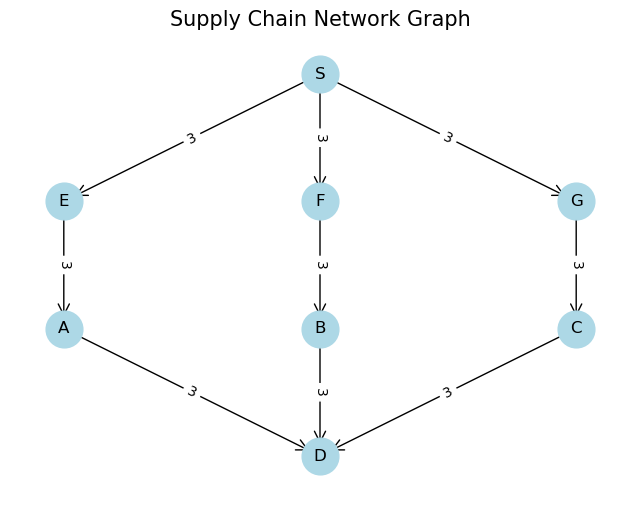

In [32]:
env.render_network()

In [33]:
def compute_safety_stock(actual_demands, service_level=0.95, lead_time=3):
    """
    Compute the required safety stock based on actual demands, desired service level, and lead time.
    
    Parameters:
    - actual_demands: numpy array of actual demands (rows: periods, columns: nodes).
    - service_level: desired service level (default is 0.95).
    - lead_time: lead time in days (default is 3).
    
    Returns:
    - safety_stock: numpy array of safety stock for each product.
    """
    # Calculate the standard deviation of the daily demands
    std_dev = np.std(actual_demands, axis=0)

    # Calculate the Z-score for the desired service level
    Z = norm.ppf(service_level)

    # Adjust for lead time variability
    lead_time_std_dev = std_dev * np.sqrt(lead_time)

    # Calculate safety stock
    safety_stock = Z * lead_time_std_dev

    return safety_stock

In [34]:
# Main simulation loop
episodes = 10
service_level = 0.95
lead_time = 3

# Compute safety stock for each node
safety_stock = compute_safety_stock(env.actual_demands, service_level, lead_time)

simulation_results = []

for episode in range(1, episodes + 1):
    state = env.reset()[0]
    done = False
    score = 0
    timesteps = 0
    cool_down = [1] * len(env.graph.nodes)

    # To track reorder points for each node
    reorder_points = {i: [] for i, node in enumerate(env.graph.nodes) if node not in ["S", "D"]}

    while not done:
        # Get current stock levels
        stock = state["inventory_levels"]
        action = [0] * len(stock)  # Initialize actions

        for i, node in enumerate(env.graph.nodes):
            if node not in ["S", "D"]:  # Ignore source and destination nodes
                # Get safety stock level for the node
                node_safety_stock = safety_stock[i]

                # Determine reorder point (safety stock + lead time demand)
                avg_demand = np.mean(env.actual_demands[:, i])  # Average daily demand
                reorder_point = (avg_demand * (lead_time + 1)) + node_safety_stock
                reorder_points[i].append(reorder_point)  # Track reorder point for the node

                # Policy to avoid stockouts based on reorder point
                if stock[i] <= reorder_point and cool_down[i] == 0:
                    action[i] = 2  # Order more stock
                    cool_down[i] = lead_time - 1  # Reset cooldown for the node
                else:
                    action[i] = 0  # No action, stock is above reorder point
                    cool_down[i] = max(0, cool_down[i] - 1)

        timesteps += 1

        # Take action and update environment
        n_state, reward, done, info, _ = env.step(action)
        score += reward

        # Update state
        state = n_state

    # Compute average reorder points for each node
    avg_reorder_points = {node: round(np.mean(points), 2) for node, points in reorder_points.items()}

     # Store results for this episode
    simulation_results.append({
        "episode": episode,
        "score": score,
        "timesteps": timesteps,
        "avg_reorder_points": avg_reorder_points
    })

    print(f"Episode {episode} Score: {score} Timesteps: {timesteps}")
    print(f"Average Reorder Points per Node: {avg_reorder_points}\n")


# Save results to a JSON file
output_file = "./Data/Evaluation/evaluation_results_calculated.json"
with open(output_file, "w") as file:
    json.dump(simulation_results, file, indent=4)

print(f"Simulation results saved to {output_file}")

IndexError: index 3 is out of bounds for axis 0 with size 3

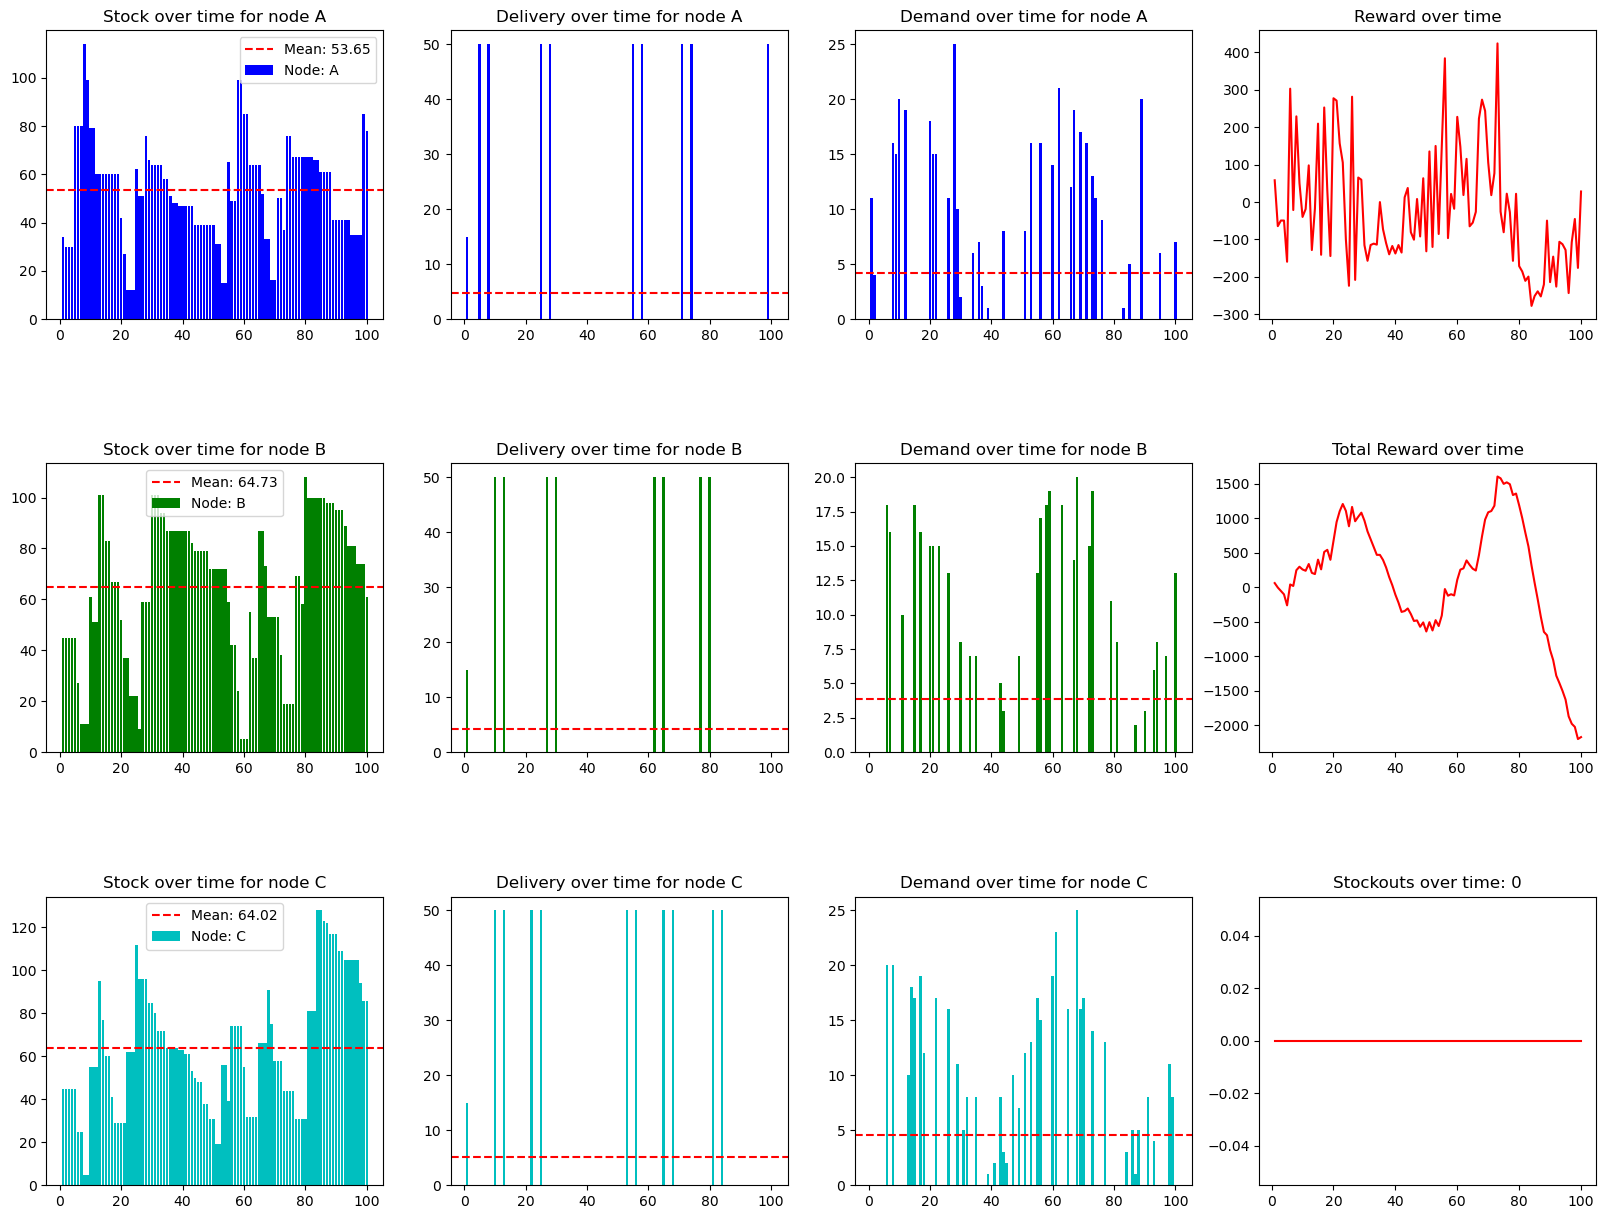

In [ ]:
df = pd.read_csv('./Data/2024-12-16_environment_data_heuristic.csv')
plot_data(df)